In [1]:
from sea_breeze import load_obs, sea_breeze_funcs
import xarray as xr
from sea_breeze.sea_breeze_funcs import *

In [60]:
stn_obs = load_obs.load_half_hourly_stn_obs("WA",slice("2016-01-01","2016-02-01")).sel(time=stn_obs.time.dt.minute==0)

In [3]:
f1 = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/era5.nc")
f2 = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/barra_r.nc")
f3 = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/barra_c.nc")
f4 = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/aus2200.nc")

In [63]:
def hourly_change(q, t, u, v, angle_da, lat_chunk="auto", lon_chunk="auto"):

    """
    Calculate hourly changes in q, t, and onshore wind speed. Use thresholds on each to define candidate sea breezes 

    ## Input
    * q: xarray dataarray of specific humidity in kg/kg

    * t: xarray dataarray of air temperature in degrees

    * u: xarray dataarray of u winds in m/s

    * v: xarray dataarray of v winds in m/s

    * angle_da: xarray dataset containing coastline angles ("angle_interp")

    ## Output:
    * xarray dataset
    """

    if ("lat" in list(q.dims)) & ("lon" in list(q.dims)):
        #Rechunk data in one time dim
        q = q.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})
        u = u.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})
        v = v.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})
        t = t.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})

    #Convert hus to g/kg 
    q = q * 1000
    
    #Define angle of coastline orientation from N
    theta=angle_da 
    
    #Rotate angle to be perpendicular to theta, from E (i.e. mathamatical angle definition)
    rotated_angle=(((theta)%360-90)%360) + 90   
    
    #Define normal angle vectors, pointing onshore
    cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]
    
    #Calculate the wind component perpendicular and parallel to the coast by using the normal unit vectors
    vprime = ((u*cx) + (v*cy))

    #Calculate the rate of change
    wind_change = vprime.differentiate("time",datetime_unit="h")
    q_change = q.differentiate("time",datetime_unit="h")
    t_change = t.differentiate("time",datetime_unit="h")  

    if "height" in list(wind_change.coords.keys()):
        wind_change = wind_change.drop_vars("height")
    if "height" in list(wind_change.coords.keys()):        
        t_change = t_change.drop_vars("height")

    ds = xr.Dataset(
        {"wind_change":wind_change,
         "q_change":q_change,
         "t_change":t_change,
            })
    ds["wind_change"] = ds["wind_change"].assign_attrs(
        units = "m/s/h",
        long_name = "Onshore wind speed rate of change",
        description = "Rate of change of onshore wind speed in m/s/h.")
    ds["t_change"] = ds["t_change"].assign_attrs(
        units = "K/h",
        long_name = "Local temperature rate of change.",
        description = "Rate of change of temperature.")      
    ds["q_change"] = ds["q_change"].assign_attrs(
        units = "g/kg/h",
        long_name = "Local specific humidity rate of change.",
        description = "Rate of change of specific humidity.")
    
    return ds

In [37]:
stn_angles1 = f1.sel(xr.Dataset({"lat":stn_obs.lati,"lon":stn_obs.long}),method="nearest")
stn_angles2 = f2.sel(xr.Dataset({"lat":stn_obs.lati,"lon":stn_obs.long}),method="nearest")
stn_angles3 = f3.sel(xr.Dataset({"lat":stn_obs.lati,"lon":stn_obs.long}),method="nearest")
stn_angles4 = f4.sel(xr.Dataset({"lat":stn_obs.lati,"lon":stn_obs.long}),method="nearest")

In [40]:
print(stn_angles1.sel(station=41).angle_interp.values,
      stn_angles2.sel(station=41).angle_interp.values,
      stn_angles3.sel(station=41).angle_interp.values,
      stn_angles4.sel(station=41).angle_interp.values)

177.60167544280495 177.3016390150995 172.84562331860383 171.3888536421527


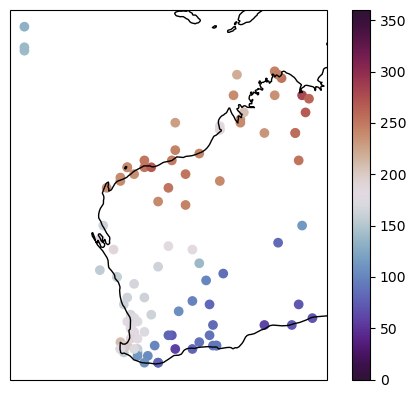

In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs



ax=plt.axes(projection=ccrs.PlateCarree())
plt.scatter(stn_angles.lon,stn_angles.lat,marker="o",c=stn_angles.angle_interp,cmap="twilight_shifted",vmin=0,vmax=360)
plt.colorbar()
ax.coastlines()

In [75]:
obs_hourly_change = hourly_change(stn_obs["hus"],stn_obs["temp"],stn_obs["u"],stn_obs["v"],stn_angles1["angle_interp"])
obs_fuzzy = sea_breeze_funcs.fuzzy_function_combine(
    obs_hourly_change.wind_change,
    obs_hourly_change.q_change,
    obs_hourly_change.t_change,
    combine_method="mean")

In [84]:
barra_c = xr.open_dataset("/g/data/gb02/ab4502/sea_breeze_detection/barra_c/fuzzy_mean_201601010000_201601312300.nc").__xarray_dataarray_variable__
barra_c_stns = barra_c.sel(xr.Dataset({"lat":stn_obs.lati,"lon":stn_obs.long}),method="nearest")

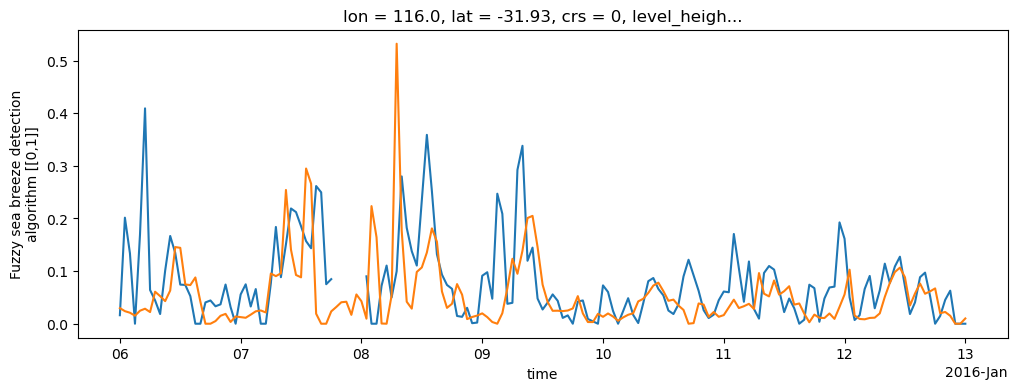

In [85]:
plt.figure(figsize=[12,4])

obs_fuzzy.sel(station=41,time=slice("2016-01-06 00:00","2016-01-13 00:00")).plot()
barra_c_stns.sel(station=41,time=slice("2016-01-06 00:00","2016-01-13 00:00")).plot()


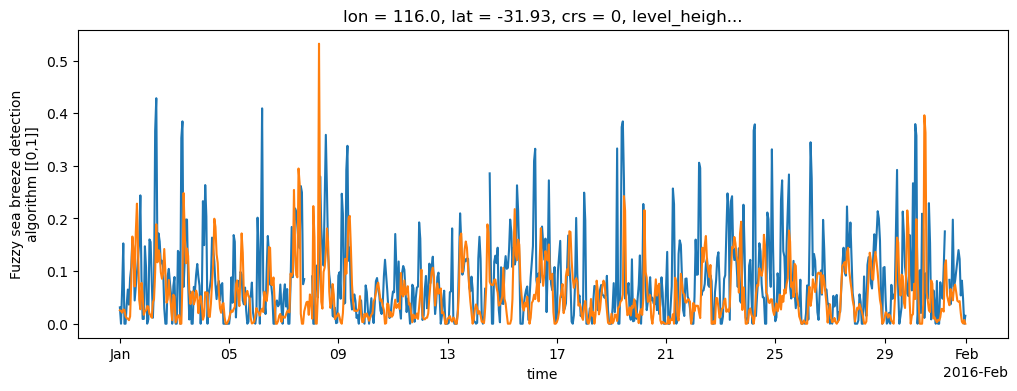

In [116]:
plt.figure(figsize=[12,4])

obs_fuzzy.sel(station=41,time=slice("2016-01-01 00:00","2016-01-31 23:00")).plot()
barra_c_stns.sel(station=41,time=slice("2016-01-01 00:00","2016-01-31 23:00")).plot()


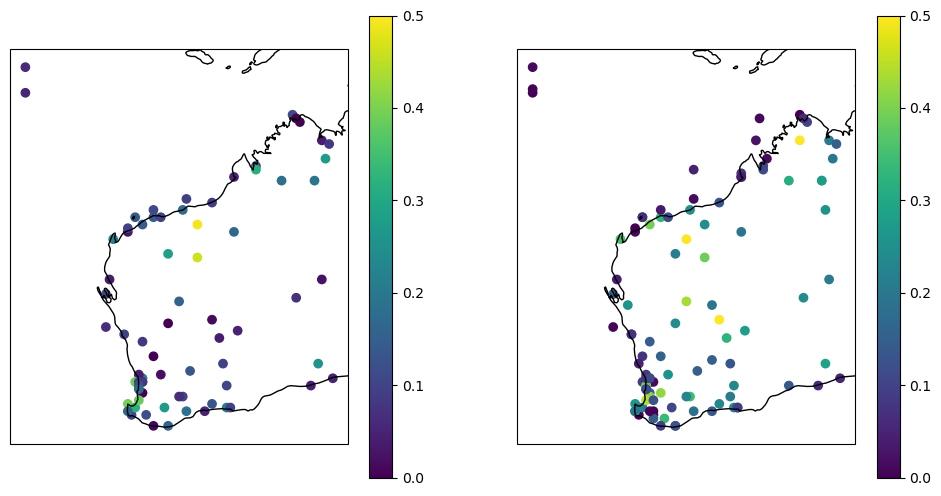

In [114]:
plt.figure(figsize=[12,6])
t="2016-01-8 10:00"

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
plt.scatter(stn_angles.lon,
            stn_angles.lat,
            marker="o",
            c=obs_fuzzy.sel(time=t),vmin=0,vmax=0.5)
plt.colorbar()
ax.coastlines()


ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
plt.scatter(stn_angles.lon,
            stn_angles.lat,
            marker="o",
            c=barra_c_stns.sel(time=t),vmin=0,vmax=0.5)
plt.colorbar()
ax.coastlines()

In [120]:
obs_fuzzy

Magnitude,[[0.0 0.0 0.0 ... nan 0.0 nan] [0.010589473292585071 0.1391537552190056 0.0019247004215442061 ... nan 0.0 nan] [0.01697893074711672 0.07014649975026079 0.08131510147662786 ... nan 0.0 nan] ... [0.017121620161714108 0.1881284429869374 0.007366510450250535 ... nan 0.06266780992569256 nan] [0.0016069795767637955 0.025243902607489085 0.020691589648111467 ... nan 0.025782646071376494 nan] [0.0 0.0 0.037724791380413396 ... nan 0.06894925158244282 nan]]
Units,dimensionless


In [ ]:
xr.merge((xr.Dataset({"obs":obs_fuzzy}),
          xr.Dataset({"obs":barra_c_stns})))